# Data Science Techniques and Algorithms

In this section of the tutorial, we'll gain an understanding for how to approach a **machine learning** problem and implement a benchmark machine learning algorithm. 

We'll start with a common dataset in the standard **attribute-predictor format**, and then venture into machine learning with **image data**. 

### Attribute-Predictor Data
Let's first load our dataset. We'll look at the common **Breast Cancer dataset**, available in **ARFF** format. 

This dataset contains statistical information about **cell nuclei** as seen in digitized images from breast mass fine needle aspirates (FNA), a common type of biopsy. 

The information in each example either represents a group of benign or malignant cancer nuclei. 

Our **Goal** is to use machine learning to **recognize a relationship** between the statistical information (`data`) and the `target` of "malignant" or "benign", so we can *predict malignancy in new images* that do not have a label assigned to them. 

In [1]:
import pandas as pd
import matplotlib
from sklearn.datasets import load_breast_cancer

In [2]:
bc = load_breast_cancer()
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

The first thing to notice is that our data are organized into **attributes**. 

These can be thought of as *categorical properties* of the dataset, representing various **aspects** of the data. It looks like we have **10 properties**, each of which is represented by **3 statistical measures**: mean, standard error, and largest values. 

+ The **mean** offers the average of an attribute's values for a given instance, providing *summary* information. 
+ The **standard deviation** offers information about the *variance* of the attribute's values; 
    + i.e., how much do the values deviate from the mean. 
+ The **largest value** is a less common statistic, but seems fitting for cancer data, in which we expect cell nuclei of malignant cancer cells to be larger than benign cancer nuclei. 

Each **example** or **instance** of our data represents a separate fine needle aspirate with its own nuclei characteristics. Here, we put our data into an object from the `pandas` library (imported as `pd`) called a `DataFrame`. This object is designed to store a table of data. We use the optional argument `columns` to store the names of each attribute being measured.

In [3]:
bc_df = pd.DataFrame(bc.data, columns=bc.feature_names)
bc_df.insert(len(bc_df.columns), 'target', bc.target)

In [4]:
bc_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


If you have data of your own you want to analyze you can store it in `DataFrame` as well. The constructor can take in a `numpy` array, or a list of lists, or you could read the data from a .csv file in the same directory as your python code with the [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function (Excel files can be exported as .csv files too!).

### Data Exploration

It's always a good idea to explore your data a bit before throwing it into an algorithm.

This can help you find **anomalies** in the data, determine what **preprocessing** steps may be needed, choose which types of **algorithms** to use, etc. 

#### Histogram

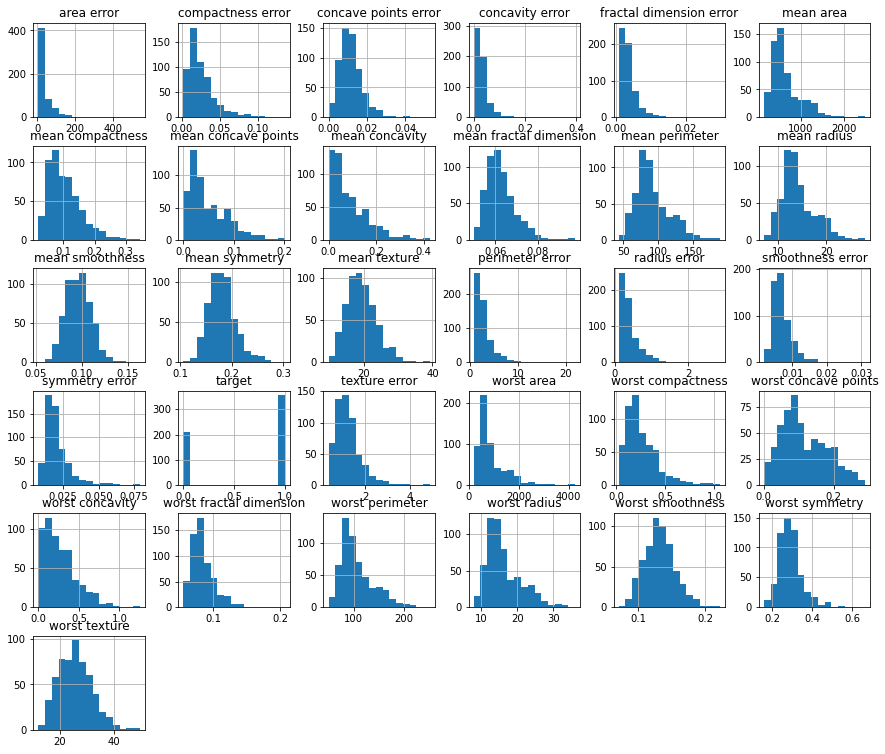

In [5]:
%matplotlib inline
hist = bc_df.hist(bins=15, figsize=(15,13))

Histograms show the **distribution** of an attribute, and can allow us to form initial **hypotheses** about the data. 

Above, we see that some of the mean and "worst" attributes are **normally distributed**, and many of the "error" attributes show highest frequency around 0 and a tail to the right. Both of these are expected. 

We also see a tendency for **skewness** in the distributions toward the right. We might hypothesize that malignant nuclei tend to have larger means and larger "worst" statistics, and are thus responsible for the right skew.

It can be useful to compare the distributions of various attributes. For example, let's look at the **means**.

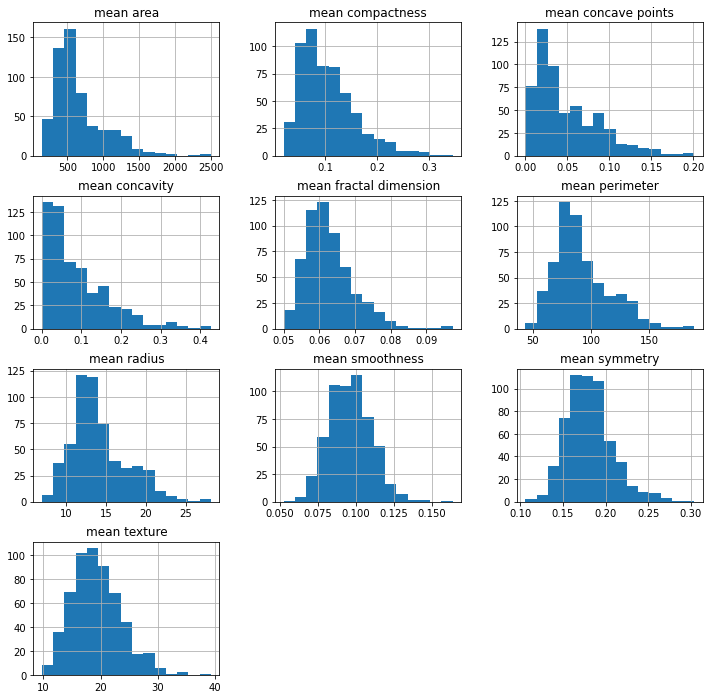

In [6]:
means = list([att for att in bc.feature_names if 'mean' in att])
hist = bc_df[means].hist(bins=15, figsize=(12,12))

Unfortunately, the ranges for these attributes are not the same, so direct comparison is not feasible. Let's **standardize** the values. 

In [11]:
from sklearn.preprocessing import MinMaxScaler

x = bc_df.to_numpy()[:,:-1] #returns a numpy array without target column
print(x.shape)

min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

bc_df = pd.DataFrame(x_scaled, columns=bc.feature_names)
bc_df.insert(len(bc_df.columns), 'target', bc.target)

bc_df.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0


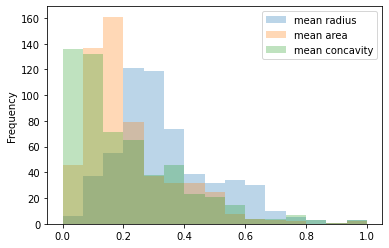

In [12]:
hist = bc_df[['mean radius','mean area','mean concavity']].plot.hist(bins=15, alpha=0.3)

#### Relationship

Next, let's look at the relationship between an attribute and the binary predictor. 

We see that `mean concavity` has the highest skewed histogram. Based on our hypothesis that skewness is due to malignancy, let's check the predictive value of this attribute. 

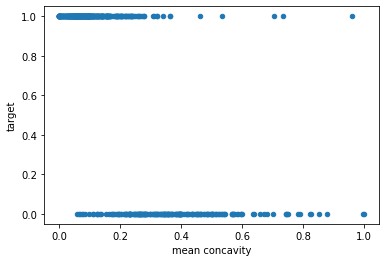

In [13]:
scatt = bc_df.plot.scatter(x='mean concavity',y='target')

We can see that values below ~0.04 will most certainly be classified as `benign` (class label of `0` = malignant) and above 0.39 will likely be labeled `malignant`. 

There's still considerable overlap between 0.04 and 0.4, so let's see if information from *other attributes* helps us predict the right class.

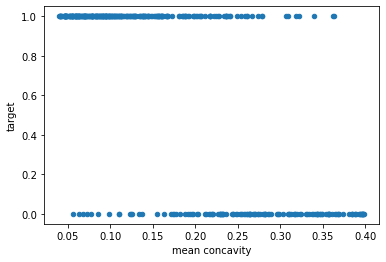

In [14]:
overlap = bc_df[(bc_df['mean concavity'] >= 0.04) & (bc_df['mean concavity'] <= 0.4)]
scatt1 = overlap.plot.scatter(x='mean concavity', y='target')

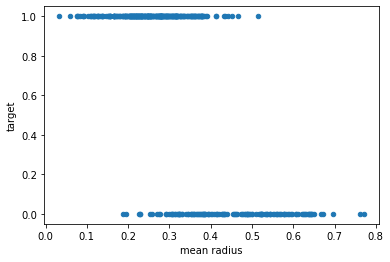

In [15]:
scatt2 = overlap.plot.scatter(x='mean radius', y='target')

It is now apparent that among the examples with `mean concavity` values between 0.04 and 0.4, if an example has `mean radius` of 0.25 or less, we will predict `benign`, and we will predict `malignant` for values above 0.4. 

Now, our uncertainty is reduced to examples with `mean concavity` between 0.04-0.4 *and* `mean radius` between 0.25-0.4. 

In [16]:
print(f"Our uncertainty based solely on Mean Concavity consists of {len(overlap)} values.")

overlap2 = overlap[(overlap['mean radius']>= 0.25) & (overlap['mean radius'] <= 0.4)]
print(f"And our uncertainty based on Mean Concavity AND Mean Radius consists of {len(overlap2)} values.")

print(f"We've reduced our uncertainty by a factor of {len(overlap)/len(overlap2):.2f}!!")

Our uncertainty based solely on Mean Concavity consists of 417 values.
And our uncertainty based on Mean Concavity AND Mean Radius consists of 184 values.
We've reduced our uncertainty by a factor of 2.27!!


Given this newfound confidence, let's design a **classification rule** that predicts `benign` if the values are below 0.35 and `malignant` if they're above. 

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig = plt.scatter(overlap['mean radius'], overlap['target'])
plt.axvline(x=0.35,color='red')

Essentially, we've manually conducted the initial steps of a **decision tree**. 

Our decision tree works as follows: 
1. If `mean concavity` < 0.04: `target` = `benign`
2. If `mean concavity` > 0.4: `target` = `malignant`
3. If `mean radius` < 0.35: `target` = `benign`
4. Otherwise, `target`=`malignant`


In [ ]:
pred=[]
for idx in range(len(bc_df['target'])):
    if bc_df['mean concavity'][idx]<0.04: pred.append(1)
    elif bc_df['mean concavity'][idx]>0.4: pred.append(0)
    elif bc_df['mean radius'][idx]<0.35: pred.append(1)
    else: pred.append(0)

misclass=0
for predxn in range(len(pred)):
    if pred[predxn]!=bc_df['target'][predxn]: misclass+=1

error = misclass/len(bc_df)*100

print(f"Our decision tree achieved {100-error:.2f}% accuracy.")

## Intro to Machine Learning

We've just manually / conceptually performed a very basic algorithm for data analysis, similar to those used by machine learning alorithms. 

Our algorithm:
1. We first performed a "prediction" using a single attribute. 
2. We (conceptually) saw that predicting based on this single attribute results in large uncertainty. 
    + Uncertainty is a source of **misclassifications**, or **error** in our predictions. 
3. We then **updated** our initial model, thereby improving our prediction. 

Machine learning algorithms attempt to **model some aspect(s) the data space** by making predictions, observing the error from those predictions, and updating the model to reduce the error. 

**Machine Learning** involves the following elements:

+ **Dataset**
    + The Law of Large Numbers allows us to utilize a representative *sample* of our population, assuming the dataset is **i.i.d.**
+ **Task**
    + Our algorithm will be given a task to perform on this dataset
    + e.g., **Classification** vs. **Regression**
    + **Supervised** vs. **Unsupervised**
+ **Model**
    + We will choose a model to perform the task
    + e.g., linear, non-linear, parametric, non-parametric
+ **Loss Function**
    + The loss function for our model allows us to compute the performance of our model and update its parameters accordingly
    + e.g., squared error, 0-1 loss, cross-entropy
+ **Training**
    + Optimization, Solver, Cross Validation, etc. 
+ **Evaluation**
    + Utilizing Performance measures
    + e.g. F1 score

### Linear Regression

Our prediction above could be improved in two ways:
1. We only use two of the 30 attributes. 
    + Manual analysis of more than 2-3 attributes at a time is very difficult
2. We used a vertical line to separate the data.
    + It is difficult to manually estimate what slope a line should be and where the center of mass in a group of data lies.

**Linear regression** seeks to "**fit**" the data points so as to describe the target variable *as a function of* the data. I.e., as values of the data change along this line of best fit, the corresponding target value should change in a linear and predictable way. 

Recall: ` y = mx + b `

This hallmark equation from grade school shows how a group of data points (`x`) can undergo simple linear combinations to produce an output (`y`). Here, `m` represents the **slope** and `b` is our **bias** term. 

In Statistics, we typically write this as $y = \beta_{1} x + \beta_{0}$. We express the output in terms of the **expectation** of **random variable Y *given* data X**, $\mathop{\mathbb{E}}[Y | X]$.

( The bias represents information about our output `y` that the model `mx` cannot or does not predict, termed **uncontrollable error**. If there were no relationship between `y` and `x` (i.e., the **null hypothesis** $\beta_0$), then we would set `m`=0 and use solely the bias term `b` to predict a constant value `y`=`b`. Typically, however, the bias helps account for noise in the data, which we do not want our model to predict. )

We can extend the equation to predict many points **`y`** from a vector of inputs **`x`**. Linear regression finds the single value `m` that, when applied to each individual `x`, predicts an output `y`. This gives us a single value `m` that describes the entire dataset.  

The output `y` is a vector of **probabilities**

In [ ]:
train = bc_df.iloc[:int(len(bc_df)*0.8)]
test = bc_df.iloc[int(len(bc_df)*0.8):]
test_labels = test['target']
test = test.drop('target',axis=1)

Linear regression can be easily implimented using the wonderful `scikitlearn` library!

In [ ]:
from sklearn.linear_model import LinearRegression

We'll first perform **Simple Linear Regression**; i.e., we'll only use a single attribute from the data and thus fit a single coefficient to that attribute. 

In [ ]:
reg = LinearRegression().fit(train['mean concavity'].values.reshape(-1,1), train['target'].values.reshape(-1,1))
m = reg.coef_
b = reg.intercept_
simple_pred = reg.predict(test['mean concavity'].values.reshape(-1,1))

for sp in range(len(simple_pred)):
    if simple_pred[sp]>=0.5: simple_pred[sp]=1
    else: simple_pred[sp]=0

print(f"Our fitted coefficient equals {m[0][0]:.4f}.")

In [ ]:
misclass=0
for predxn in range(len(simple_pred)):
    if simple_pred[predxn]!=test_labels.values[predxn]: misclass+=1

error = misclass/len(test_labels)*100
print(f"Simple Linear Regression achieved {100-error:.2f}% accuracy.")

In [ ]:
fig = plt.scatter(train['mean concavity'], train['target'])
lobf = m * train['mean concavity'].values.reshape(-1,1) + b
plt.plot(train['mean concavity'].values,lobf,color='red')

#### Multiple Linear Regression

Linear regression is further extendable to predict outcomes `y` given any number of attributes. Our input vector **`x`** becomes our dataset matrix `X`, with a column for each attribute and a row for each instance. 

We now fit a `m` **coefficient** for *each* attribute, resulting in a **`w`** vector. Similarly, each attribute gets a bias term. 

$$\vec y=X\vec w$$


$$X=\begin{bmatrix}
1 & x_{1,1} & x_{1,2} & \cdots  & x_{1,n}\\ 
1 & x_{2,1} & \ddots &  & \vdots\\
\vdots &  \vdots &  &  \ddots& \vdots\\
1 &  x_{m,1}& \cdots &  \cdots& x_{m,n}\\ 
\end{bmatrix}$$

$$\vec y=X\vec w\implies \vec w= X^{-1}\vec y \text{  iff  } X^{-1} \text{  exists}$$
Instead, we can rely on a special matrix $X^\intercal X$ which is guaranteed to have an inverse so long as the columns of X are linearly independent. So then,

$$\vec y=X\vec w\implies X^\intercal\vec y=(X^\intercal X)\vec w\implies (X^\intercal X)^{-1}X^\intercal\vec y=(X^\intercal X)^{-1}(X^\intercal X)\vec w=I\vec w=\vec w$$

In [ ]:
mult_reg = LinearRegression().fit(train.iloc[:,:-1].values, train['target'].values)
mult_pred = mult_reg.predict(test.values)

for mp in range(len(mult_pred)):
    if mult_pred[mp]>=0.5: mult_pred[mp]=1
    else: mult_pred[mp]=0

In [ ]:
misclass=0
for predxn in range(len(mult_pred)):
    if mult_pred[predxn]!=test_labels.values[predxn]: misclass+=1

error = misclass/len(test_labels)*100
print(f"Multiple Linear Regression achieved {100-error:.2f}% accuracy.")

### Logistic Regression

There are some limitations with Linear Regression. As can be seen in the plot above, the result of linear regression is a **line** of best fit with range -$\infty$ to $\infty$. 

However, since we are dealing with **classification**, we only want predictions at 0 or 1. 

It is difficult to interpret what a prediction less than 0 or greater than 1 means. 

Additionally, we must arbitrarily set a **threshold** between 0 and 1, above which all predictions become `1` and below which all predictions become `0`. If many predictions are near the threshold, the potential for error is high. 

As such, it is desirable to define the line of best fit as a **sigmoid** curve.

In [ ]:
""" source: http://squall0032.tumblr.com/post/77300791096/plotting-a-sigmoid-function-using """
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

As we can see, the sigmoid curve lies in the range [0,1] and concentrates most of its values around 0 and 1. The "s"-like curvature keeps the function continuous, meaning it is differentiable. We'll return to this point in the next section. 

As we can see above, the equation for the sigmoid function is $\sigma (x)=\frac{1}{1+e^{-x}}$. Given a Bernoulli random variable $Y$ with only two classes, e.g., $1$ and $0$, we can write $p(x) = \mathop{\mathbb{P}}[Y=1 | X=x]$. So by our model, we assert that $$p(x)=\sigma (x)=\frac{1}{1+e^{-x}}$$, but we'd like to parameterize this as $$\frac{1}{1+e^{-(\beta^Tx + \beta_{0})}}$$. In order to do so, we need to solve for $(\beta^Tx + \beta_{0})$, or if we simplify it as $x'=(\beta^Tx + \beta_{0})$, then we only need to solve for $x'$ in $p(x')$.

$$p(x')=\frac{1}{1+e^{-x'}}\implies\frac{1}{p(x')}=1+e^{-x}\implies\frac{1}{p(x')}-1=e^{-x}\implies\frac{1-p(x')}{p(x')}=e^{-x}\implies\frac{p(x')}{1-p(x')}=e^x\implies \operatorname{ln}(\frac{p(x')}{1-p(x')})=x$$

So finally, we have our model: $$p(x)=\frac{1}{1+e^{-(\beta^Tx + \beta_{0})}}$$
Now that we have our new model for our data, we aim to fit this model by tuning the coefficients $\beta$.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(train.iloc[:,:-1].values, train['target'].values)
logr_pred = logreg.predict(test.values)

In [ ]:
misclass=0
for predxn in range(len(logr_pred)):
    if logr_pred[predxn]!=test_labels.values[predxn]: misclass+=1

error = misclass/len(test_labels)*100
print(f"Logistic Regression achieved {100-error:.2f}% accuracy.")

### Optimization

We've seen two examples of *modeling* the data, as either a straight line or a sigmoid curve. However, both of these models involve **parameters** that need to be solved to make the models **fit** the data. 

There are infinite possible straight lines or sigmoid curve variations we could potentially model the data with. We need to find the *best fit* in an efficient way... 

**Optimization** is the process of **maximizing** some parameterized **function** based on a **metric** (or **minimizing** based on its negative).

##### Which objective function are we minimizing?

For the case of **linear regression**, it is simple to look at the *number of misclassified examples*, or the **error** on our predections.

More specifically, the L2 loss for linear regression, aka the **least squares equation**: 

<p style="text-align: center;"> $l(x_{i}, y_{i}) = \|(y_{i} - (\beta x_{i} + \beta_{0})\|^2$ </p>

When dealing with the entire dataset, we'll combine $\beta_{0}$ with vector $\beta$ and add a dummy column of 1's to X:

<p style="text-align: center;"> $l(X, y) = \|y - \beta^T X\|^2$ </p>

**Logistic regression** has some interesting properties that let's us minimize its function more directly. 

If we suppose `y` to take the values -1 and 1 instead of 0 and 1, we can represent `y` as follows: 

<p style="text-align: center;"> $\mathop{\mathbb{P}}[Y=1 | X=x] = \frac{1}{1 + e^{-(\beta^TX)}}$ and $\mathop{\mathbb{P}}[Y=-1 | X=x] = \frac{1}{1 + e^{(\beta^TX)}}$ </p>

This can be simplified to: $\mathop{\mathbb{P}}[Y=y | X=x] = \frac{1}{1 + e^{(-y \beta^TX)}} = \sigma(-y \beta^TX)$

For each class, we seek to **maximize** the probability that Y=y given the data, by fitting our parameters $\beta$ to the data. This is referred to as the **maximum likelihood equation**: 

<p style="text-align: center;"> ${\displaystyle \max_{\beta \in \Theta}} {\mathop{\mathcal{L}}}(\beta;X)$

where $\Theta$ represents the parameter space of all possible parameter values.

This is solved as 

$$
\begin{aligned}
  {\mathop{\mathcal{L}}}(\beta;X) &= p((x_{1},y_{1}),(x_{2},y_{2}),...,(x_{n},y_{n});\beta) \\
 &= {\displaystyle \prod_{i=1}^{n} p(x_{i},y_{i}; \beta)} \\
 &= {\displaystyle \prod_{i=1}^{n} {\rm p}^{y_{i}}(1-{\rm p})^{(1-y_{i})}},
\end{aligned}
$$
where ${\rm p} = \sigma(y_{i}\beta^TX)$ and $y_{i}$ is a **Bernoulli** variable.

The **log likelihood function** is more convenient to use:

$$
\begin{aligned}
\log {\mathop{\mathcal{L}}}(\beta;X) &= \log {\displaystyle \prod_{i=1}^{n} {\rm p}^{y_{i}}(1-{\rm p})^{(1-y_{i})}} \\
&= {\displaystyle \sum_{i=1}^{n} y_{i} \log {\rm p} + (1 - y_{i}) \log(1- {\rm p}) }
\end{aligned}
$$

This equation gives us the **cross entropy**, equivalent to the **log likelihood**

##### How can we update our parameters so as to minimize the error?

Recall: `gradient` 
 
+ Represents the line tangent to a function at a given point; i.e., the instantaneous **slope** of the line

+ At inflection points, the gradient = 0

Given that our function is **differentiable**, the loss function is also differentiable. 

Therefore, taking the gradient of the loss function will tell us the slope of our **error curve** given the input parameters. 

 $$\nabla\operatorname{log}\mathcal{L}(\beta ; X)=\frac{1}{n}\sum_{i=1}^n(\sigma (y_i\beta ^\intercal x_i)-1)y_ix_i$$

#### Gradient Descent

The negative of this gradient tells us the direction toward a (at least local) **minima**.

Thus, we can update our parameters as follows:

1. Initialize $\beta^{(0)}$
2. $\beta^{(k+1)} = \beta^{(k)} - \alpha_k \nabla l(\beta^{(k)}) $
    + $\alpha_k$ is a **learning rate** used to weight the effect of the gradient on the update
    + larger update steps can be made at the beginning of training; closer to the optimum, more refined updates should be made
3. Repeat until convergence

![](https://www.oreilly.com/library/view/learn-arcore-/9781788830409/assets/f3899ca3-835e-4d3e-8e7f-fd1c5a9044fb.png)

![](https://i.stack.imgur.com/gjDzm.gif)

## Switching Domains : Image Data

Now that we have an understanding of basic machine learning, we can switch to more complex, but interesting domain. 

**Imaging data** can be viewed just like normal datasets, where a single example is made up of n **pixels**, and each pixel represents a distinct attribute. 

Across all the example, each pixel's values take a distinct distribution, and all the pixels' distributions together make up the **data space**. 

Next, we'll apply the machine learning algorithms we've just seen as well as some new ones to the common **MNIST** image dataset.

Resources: 
+ The contents of this tutorial were done largely from memory of lessons over the years and refreshers from the internet, as well as with guidance from slides by Dr. Jaewoo Lee (CSCI 8960, UGA)

# K-Nearest Neighbors on MNIST

## What is K-Nearest Neighbors? 

K-Nearest Neighbors is a non-parametric, lazy learning algorithm. K-Nearest Neighbors seperates data into several classes in order to predict the classification of a new sample point. By __non-parametric__, we mean that it makes no assumptions about the underlying data distribution, or in other words that the model structure is determined from the data. KNN is a __lazy learning algorithm__ because there is no explicit training phase, and that its training data is needed during the testing phase in order for KNN to generalize. 

![](images/knn.png)

KNN relies on feature similarity, or how closely out-of-sample features resemble our training set. In the above picture, the new example will be classified as either a red triangle or blue square depending on how many nearest neighbors (k) we set. 

When k equals 1, the new example is classified to a blue square since the nearest neighbor is a blue square.

When k equals 3, the new example is classified to a red triangle since there are two red triangles and only one blue square.

When k equals 5, the circle is now enclosed to the first 5 datapoints that it reaches, which in this case will be 3 squares and 2 triangles. This means that the example will be classified as a square.

## KNN Applied to Digit Recognition

First, we'll import all necessary models and then load the MNIST dataset. We're primarily concerned with the ```mnist.data``` and ```mnist.target``` columns. ```mnist.data``` contains 784 columns for each pixel of a 28x28 pixel image, in which each element represents a greyscale codes from 0 to 255 at that specific pixel. ```mnist.target``` represents labels for each image.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, cache=True)

## What is MNIST?

In [ ]:
print(mnist.DESCR)

In [ ]:
mnist_df = pd.DataFrame(mnist.data, columns=mnist.feature_names)
mnist_df.insert(len(mnist_df.columns), 'target', mnist.target)
mnist_df.head()

In [ ]:
print(mnist_df['target'].value_counts())

Next, we'll separate the arrays and the classes. The shape of x is 70000 by 784, meaning that there are 784 columns (one for each pixel of the 28x28 image) and 70000 rows these arrays. The shape of y is 70000 rows of numbers from 0 to 9.

In [ ]:
X, y = mnist["data"], mnist["target"] 
X.shape

In [ ]:
y.shape

We can mess around with matplotlib to visually give us an idea of what the array's greyscale numbers mean.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[9]
some_digit_image = some_digit.reshape(28,28)
fig=plt.figure(figsize=(8, 8))
digits = X[np.random.randint(0, high=70000, size=10)]
rows = 2
columns = 5

for i in range(len(digits)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(digits[i].reshape(28,28), cmap=matplotlib.cm.binary,
              interpolation="nearest")
    plt.tight_layout()
plt.show()

## Our Data Visualized 

Before diving into the visualization of our data, let's learn what __dimensionality reduction__ is. 

__Dimensionality reduction__, put simply, is the process of reducing the dimensions of a feature set. A dataset with 100 features could be condensed to 20 meaningful features by dimensionality reduction. Who cares if we have 100 features? _What's wrong with having more features?_ More than one would think. A model that trains on numerous features becomes increasingly dependent on the data it was trained on and overfits as a result. Some of the motivations for dimensionality reduction include:

 - Avoiding overfitting
 - Remove redundant features
 - Improve computation time
 - Visualization
 
 and more!

In a dataset such as MNIST, we use dimensionality reduction strictly for visualization purposes.

It's clearly infeasible to try visualizing our data since it's in a dimensionality we couldn't begin to fathom how to visualize. Our solution to this is __dimensionality reduction__. We can reduce the data from 784 dimensions to 2 dimensions using __t-Distributed Neighbor Stochastic Embedding__, or __t-SNE__ for short. t-SNE is an unsupervised, non-linear technique used for data exploration and visualizing high-dimensional data. In short, the way t-SNE works is by calculating a probabilistic similarity measure between instance pairs in both the high dimensionality space and low dimensionality space. It then optimizes these similarity measures using a cost function. Compared to __Principal Components Analysis__ (PCA), a linear dimensionality reduction technique, t-SNE can be used to better visualize nonlinear datasets.

![](images/swissroll.png)

The solid line in the above graph represents t-SNE which preserves small pairwise distances or local similarities. The dotted line represents PCA which preserves large pairwise distances to maximize variance. What we can see from this is that PCA does not preserve the underlying structure of the dataset while t-SNE does. More information on the mathematics behind t-SNE will be linked below.

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(X[:7000])

reduced_df = np.vstack((tsne.T, y[:7000])).T
reduced_df = pd.DataFrame(data=reduced_df, columns=["X", "Y", "label"])
reduced_df.label = reduced_df.label.astype(np.int)

In [ ]:
g = sns.FacetGrid(reduced_df, hue='label', size=8).map(plt.scatter, 'X', 'Y').add_legend()

What we can gather from this visualization are a couple things. For the most part, the digits are clustered separately quite well. Of course, there are some digits that fall into other clusters where they don't belong and this can be attributed to the poor handwriting of a certain digit (an 8 can look like a 6). Notably, there isn't much separation between 4s (purple) and 9s (teal) which shouldn't come as a big surprising considering the written similarity between a 4 and a 9.

## Creating Our Train/Test Split

Now that we are more familiar with our data, we can separate it into training and test sets. There are three datasets that a data scientist will generally interact with: a training set, a validation set, and a test set. We are primarily concerned with separating our data into a test and train split since we'll be using cross validation later. So what do each of these sets mean? The __training set__ is the sample of data that we fit our model to. Our model _learns_ from this data. The __validation set__ is the sample of data we use to evaluate our model on to fine-tune our __hyperparameters__, which are the parameters of the model that we are able to explicitly change. Hyperparameters are not to be confused with __model parameters__, which are parameters that the ML algorithm will learn on its own, such as weights and biases in a linear regression model or split points in a decision tree. Finally, the __test set__ is the sample of data we wish to test our model on to provide an unbiased evaluation of our model fit on the training data. The model has _never_ seen the test set data before, and an important note is that our test set should be stratified in the same way our training set is set up. It should contain a similar proportion of classes (digits 0 through 9) as our training set. A good rule of thumb is to separate our data into 80% train and 20% test.

![](images/traintest.png)

X_train and y_train will be our training set consisting of 60000 instances, while X_test and y_test will be the remaining 10000. We'll then use np.random.permutation to shuffle the indices so that the numbers are not in order.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Training is as simple as creating a knn classifier with three neighbors required to classify and then calling knn.fit() to fit the classifier to the training set.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

## Making Sure Our Model Generalizes Well

We can get an idea of how our model will generalize by using __k-fold cross validation__ with 5 folds (generally 10 folds is recommended, but for sake of compiling time we've reduced it to 5). Cross validation can be used to attain an understanding of how well our model will generalize to unseen data. We want to make sure that our model is low on bias and variance, or in other words is not respectively underfitting or overfitting but providing an overall good fit. We use cross validation because we want to avoid the problem of reducing the amount of training data since this risks losing important patterns/trends in the dataset, which would lead to a higher error.

k-fold cross validation works by dividing the training dataset into k partitions, or folds. Each of these folds are used as a validation set once and the other k-1 sets are used to form the training set, so by the end of cross validation the training set has been validated on k sets.

![](images/crossval.png)

_An example of how 5-fold cross validation works iteratively_

In [ ]:
#cvs = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy")
#print(cvs)
#print(np.average(cvs))

Finally, we can test our model on the test set and see our accuracy. 97%, not bad!

In [ ]:
knn.score(X_test, y_test)

## Finding the Optimal Hyperparameters 

With each model data scientists use to solve a problem there exists a huge hyperparameter search space. It would be quite time consuming to hand-tune our hyperparemeters over and over again. This is where __grid search__ comes in, allowing us to search the hyperparameter space in a brute force fashion for the optimal hyperparameters. By the nature of grid search however, it is computationally complex on large datasets with large hyperparameter spaces. Therefore running grid search would be best done on a stratified subset of the training data. For the sake of time, we'll omit running the below code during the workshop.

In [ ]:
from sklearn.model_selection import GridSearchCV

# instantiate the grid
k_range = list(range(1, 5))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
#grid.fit(X_train, y_train)

# Support Vector Machine on MNIST

## What is a Support Vector Machine? 

A Support Vector Machine, or SVM, is a supervised learning algorithm that can be used for either classification or regression. The algorithm outputs a hyperplane which categorizes new examples. Given two classes, a SVM will find the hyperplane that maximizes the margin, or distance, between the nearest points of the two classes. This hyperplane is called the __maximum-margin hyperplane__. SVMs are ideal for high-dimensional data, are resilient to overfitting, and are very versatile.

![](images/svm.png)

## The Kernel Trick 

While the hyperplanes above maximize the distance between the two classes, it's often the case that our data is not linearly separable, meaning that we cannot simply divide our classes with a linear hyperplane. For cases like this, we may translate our points into a higher dimensional space using the __kernel trick__ so that we may find a clear dividing margin. There are different kernels at our disposal, such as the polynomial kernel, the radial basis function kernel, and the sigmoid kernel to name a few.

![](images/kernel.png)

## SVM Applied to Digit Recognition 

Given this plethora of information on SVMs, we can start by standardizing our data and shuffling it like before. Due to the computational complexity of a polynomial kernel SVM, we'll be working with 10000 training samples and 2000 test samples. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = X_scaled[:10000], X_scaled[68000:], y[:10000], y[68000:]
shuffle_index = np.random.permutation(10000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Creating and fitting our model is as simple as two lines of code! We should pay attention to the parameters of the support vector classifier. We are using a polynomial kernel, and our C value will denote how narrow or wide we want our margin to be. A _smaller_ C value will give us a _larger_ margin, whereas a _bigger_ C value will give us a _smaller_ margin. To elaborate, C is the sensitivity of the SVM algorithm in relation to how lenient we want the algorithm to be in misclassification. A wider margin will mean a higher likelihood of misclassification while a narrow margin will mean a lower likelihood. Gamma represents a hyperparameter that determines how much a new data point influences the curvature of our decision boundary.

In [ ]:
clf = SVC(kernel='poly', C=.001, gamma=10)

clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

## Creating a Confusion Matrix 

We know what our accuracy is now, but we want to get an idea now of how our model performed on classifying different digits. The easiest way to see our performance is by creating a __confusion matrix__. This will allow us to see how our model performed on predicting digits versus the actual values. The diagonal of the matrix represents the correct classifications and all other cells represent misclassifications. 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred).astype('int')]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


plot_confusion_matrix(y_test, y_pred, classes=np.unique(mnist['target']), title="Confusion Matrix")

We can see from the confusion matrix that the model performed very well on the 1 digit. The highest misclassification happened with 8s being predicted as 5s.  Similarly, six 2s were classified as 8s somehow. We can also gather from this confusion matrix that our subset sample had a lot of 1s and not a lot of 5s.

In [ ]:
clf.score(X_test, y_test)

## Additional Reading 

Dimensionality reduction: https://www.geeksforgeeks.org/dimensionality-reduction/

t-SNE: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1

SVM: https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72